In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
with open('dataset/gold_label_dataset.pkl', 'rb') as file:
    df = pd.compat.pickle_compat.load(file) 

In [3]:
emotions = df.columns[df.columns.str.startswith("M_")].values.tolist()
emotions = [e[2:].lower() for e in emotions]
emotions

['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'neutral',
 'sadness',
 'something else',
 'surprise',
 'trust']

## Analyze amount of labels for each

In [4]:
cols = df.columns[df.columns.str.startswith("label_")].tolist()
freq_counts = {e: dict.fromkeys(emotions, 0) for e in cols}

for index, row in df.iterrows():
    for column in cols:
        for elem in row[column]:
            freq_counts[column][elem] += 1

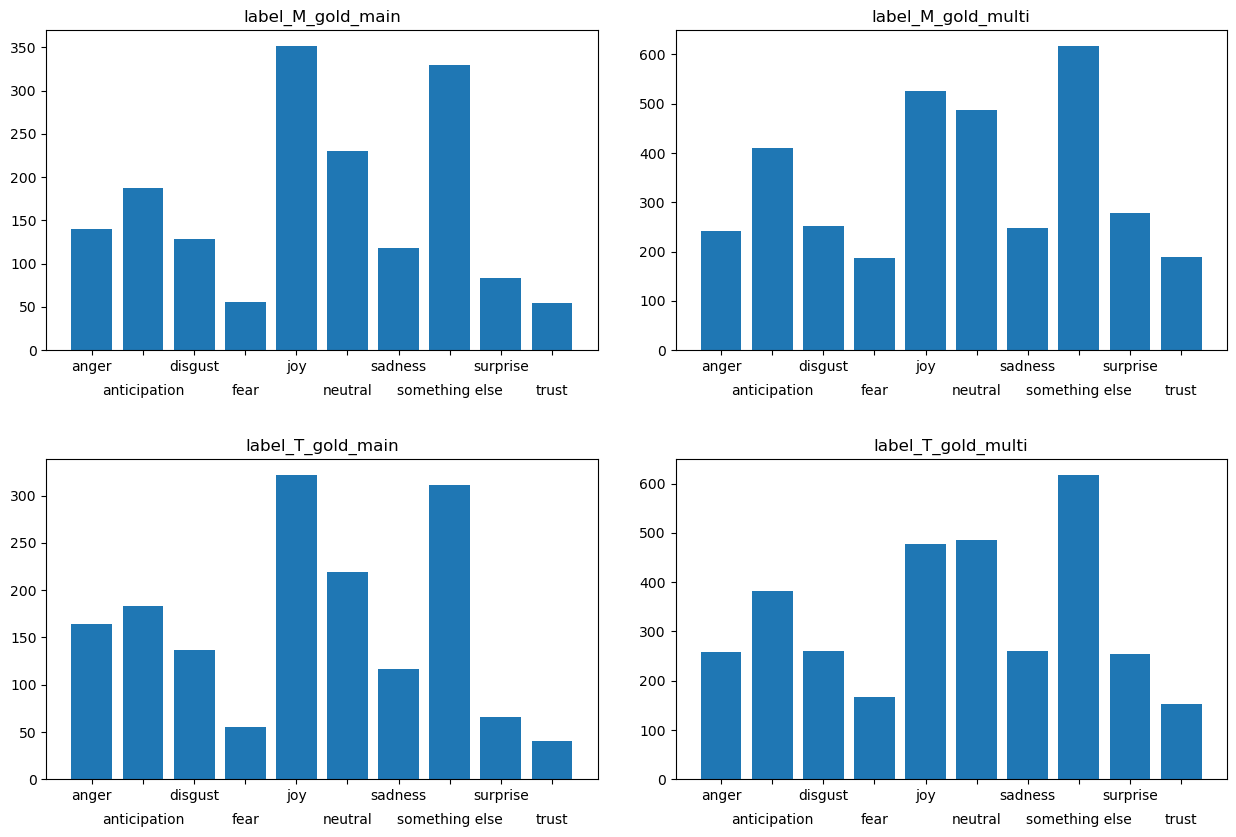

In [5]:
fig, axs = plt.subplots(2, 2, figsize = (13, 9))
for i, ax in enumerate(axs.reshape(-1)):
    ax.bar(freq_counts[cols[i]].keys(), freq_counts[cols[i]].values())
    ax.set_title(cols[i])
    labels = ax.get_xticklabels()
    for i, label in enumerate(labels):
        label.set_y(label.get_position()[1] - (i % 2) * 0.075)
fig.tight_layout(pad=3)
plt.show()

## Difference between silver and gold label

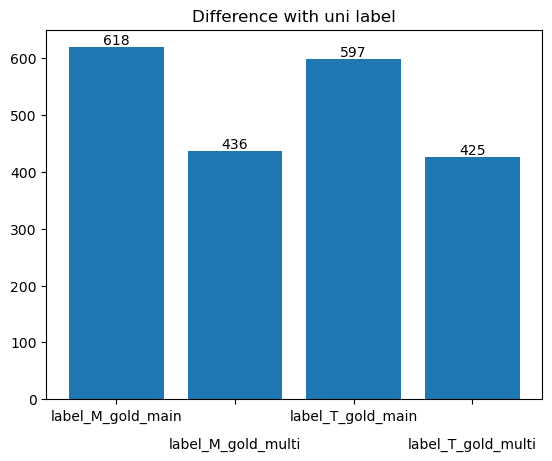

In [6]:
count_dict = {}
for column in cols:
    count = 0
    for i, row in df.iterrows():
        if row["uni_label"] not in row[column]:
            count += 1
    count_dict[column] = count

fig, ax = plt.subplots()

bars = ax.bar(count_dict.keys(), count_dict.values())
ax.bar_label(bars, count_dict.values())
labels = ax.get_xticklabels()
for i, label in enumerate(labels):
    label.set_y(label.get_position()[1] - (i % 2) * 0.075)
ax.set_title("Difference with uni label")
plt.show()
plt.close()

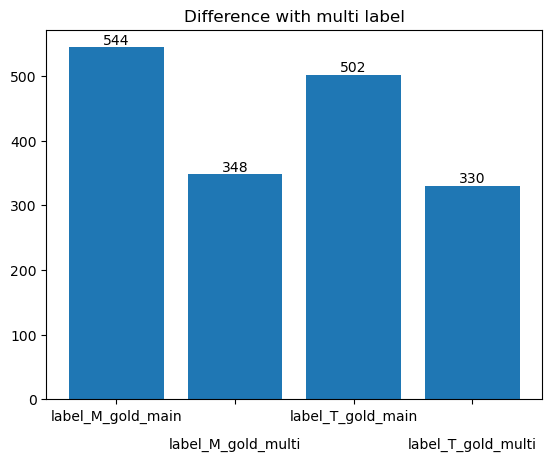

In [7]:
for column in cols:
    count = 0
    for i, row in df.iterrows():
        if set(row["multi_label"]).isdisjoint(row[column]):
            count += 1
    count_dict[column] = count

fig, ax = plt.subplots()

bars = ax.bar(count_dict.keys(), count_dict.values())
ax.bar_label(bars, count_dict.values())
labels = ax.get_xticklabels()
for i, label in enumerate(labels):
    label.set_y(label.get_position()[1] - (i % 2) * 0.075)
ax.set_title("Difference with multi label")
plt.show()
plt.close()

## Difference between text only and multimodal labels

In [8]:
count = 0
for i, row in df.iterrows():
    if set(row["label_M_gold_main"]).isdisjoint(row["label_T_gold_main"]):
        count += 1
print(count)

214


In [9]:
count = 0
for i, row in df.iterrows():
    if set(row["label_M_gold_multi"]).isdisjoint(row["label_T_gold_multi"]):
        count += 1
print(count)

28


## Correlation between label scores

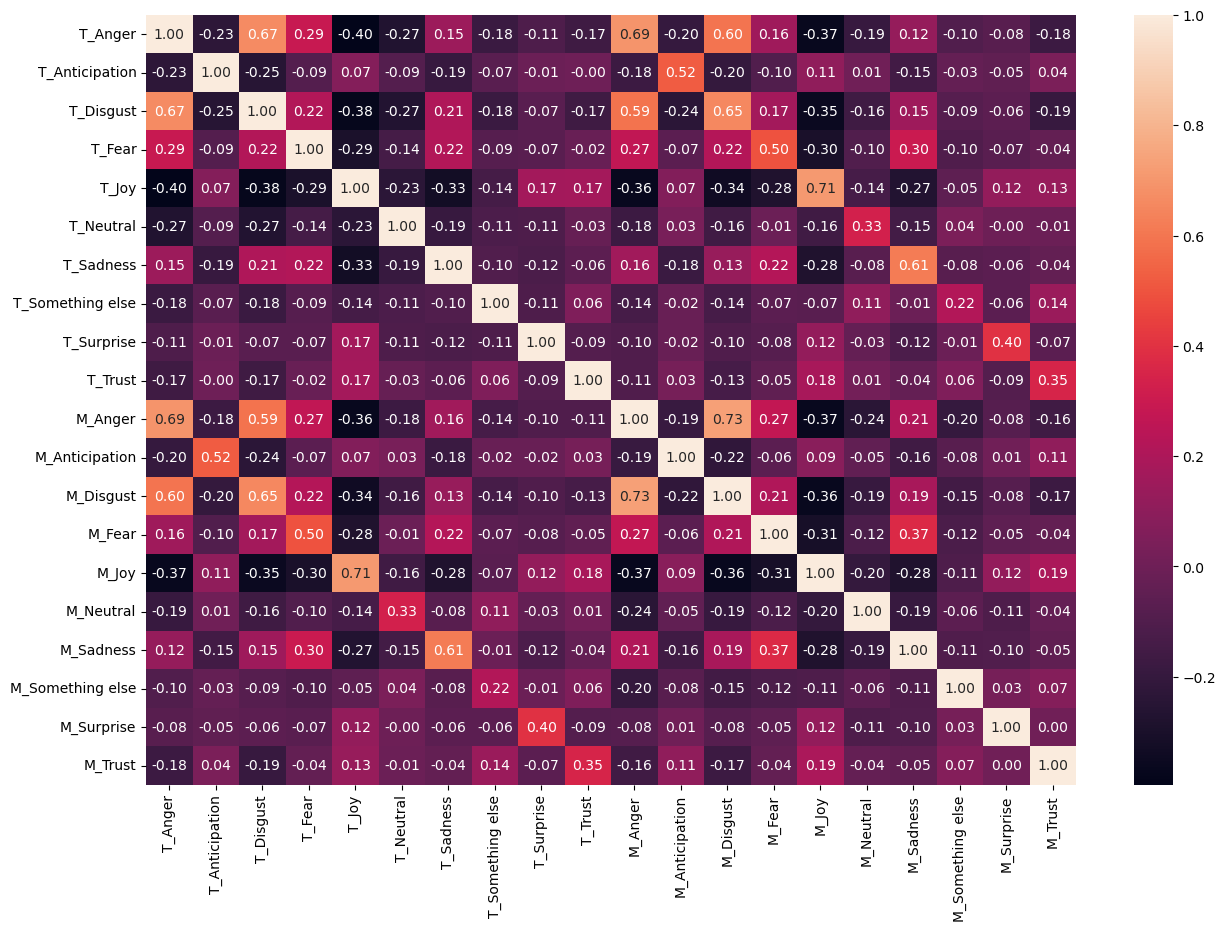

In [10]:
import seaborn as sns

cols = df.columns[df.columns.str.startswith("T_")].tolist() + df.columns[df.columns.str.startswith("M_")].tolist()
fig = plt.figure(figsize=(15, 10))
sns.heatmap(df[cols].corr(), annot = True, fmt = '.2f')
plt.show()
plt.close()

## Top images for each emotion

In [11]:
import ipyplot

In [12]:
tweets = []
images = []
labels = []
for e in emotions:
    label = f"M_{e.capitalize()}"
    for i, row in df.sort_values(label, ascending=False).head(10).iterrows():
        tweets.append(row["tweet"])
        images.append(f"dataset/gold_images/twint_images3/{row['id']}_0.jpg")
        labels.append(label)

ipyplot.plot_class_tabs(images, labels, custom_texts=tweets, show_url=False, img_width=300)

In [13]:
tweets = []
images = []
labels = []
for e in emotions:
    label = f"T_{e.capitalize()}"
    for i, row in df.sort_values(label, ascending=False).head(10).iterrows():
        tweets.append(row["tweet"])
        images.append(f"dataset/gold_images/twint_images3/{row['id']}_0.jpg")
        labels.append(label)

ipyplot.plot_class_tabs(images, labels, custom_texts=tweets, show_url=False, img_width=250)

## Wordclouds

In [14]:
from collections import Counter
from wordcloud import WordCloud
import re

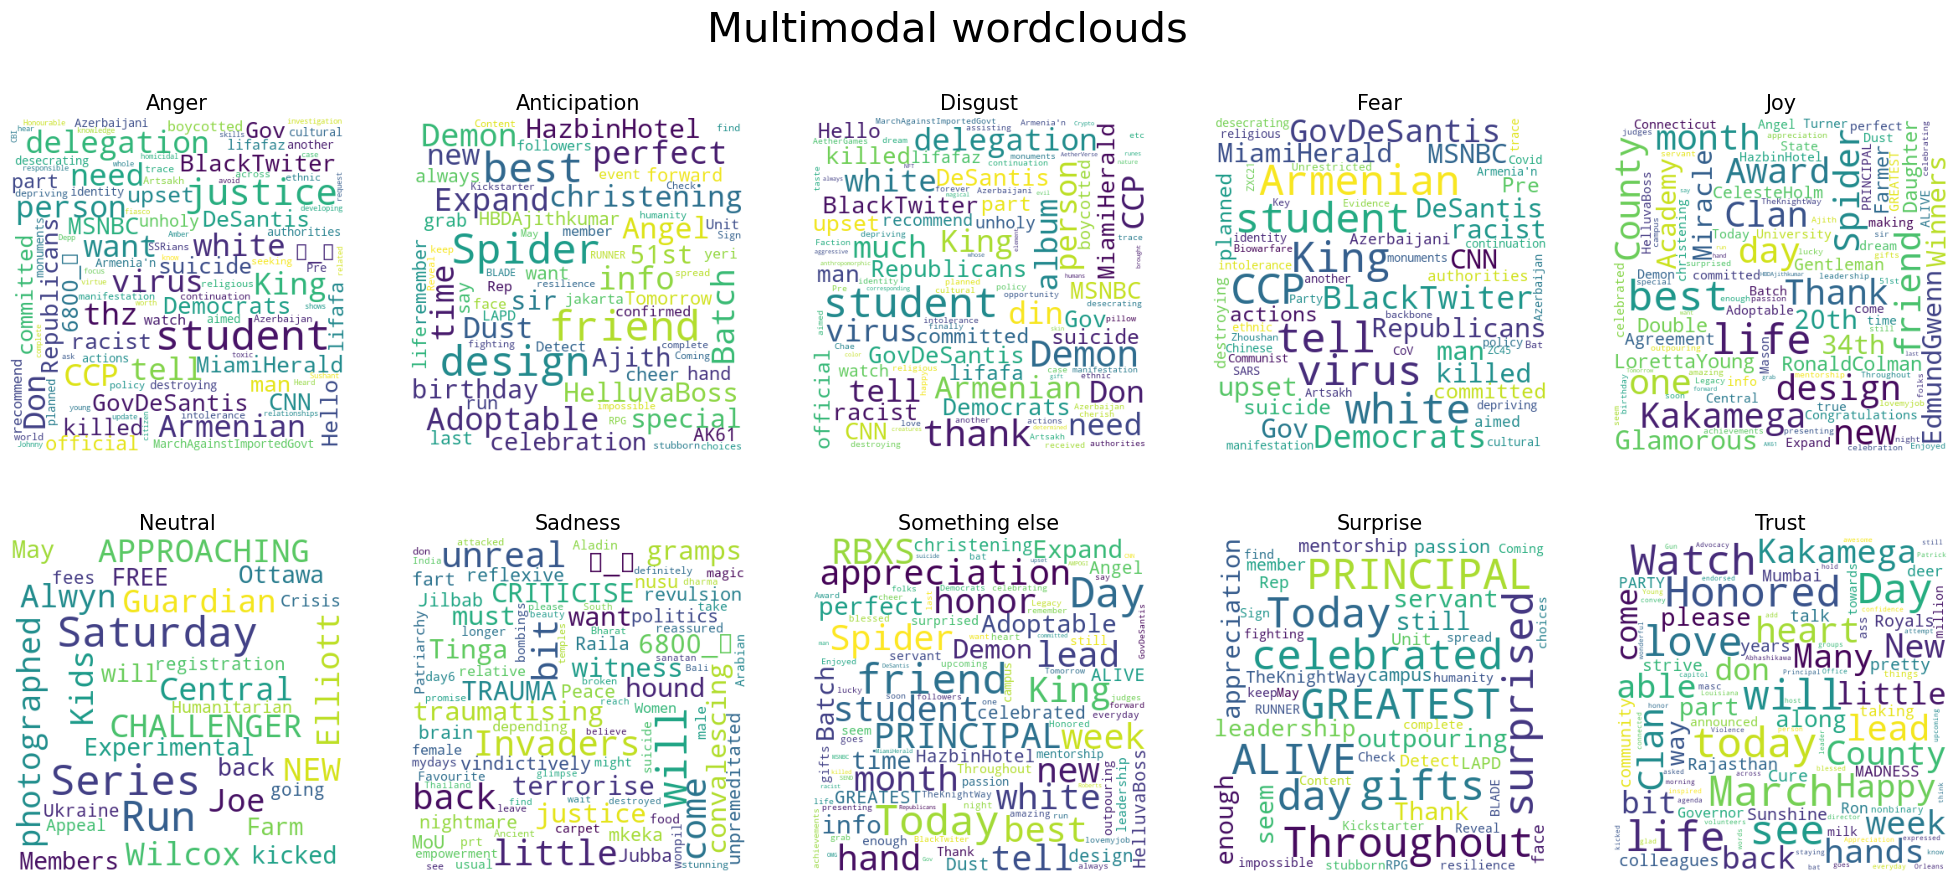

In [15]:
fig, axs = plt.subplots(2, 5, figsize=(25, 10))

for e, ax in zip(emotions, axs.flat):
    label = f"M_{e.capitalize()}"
    combined_text = ' '.join(df.loc[df[label] >= 2]['tweet'])

    pattern = re.compile("&amp")
    combined_text = re.sub(pattern, "", combined_text)

    # cleaning the tweet text, code taken from https://medium.com/codex/making-wordcloud-of-tweets-using-python-ca114b7a4ef4
    
    # remove emoji
    regex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    combined_text = re.sub(regex_pattern,'',combined_text)

    # remove urls
    pattern = re.compile(r'(https?://)?(www\.)?(\w+\.)?(\w+)(\.\w+)(/.+)?')
    combined_text = re.sub(pattern,'', combined_text)

    # remove @ mentions and hashes
    re_list = ["@[A-Za-z0–9_]+", '#']
    combined_re = re.compile( '|'.join( re_list) )
    combined_text = re.sub(combined_re,"",combined_text)
    
    

    wordcloud = (
        WordCloud(max_font_size=50, 
                max_words=100,       
                background_color="white",
                min_word_length=3,
                width=400,
                height=400)
        .generate(combined_text)
    )
    ax.set_title(e.capitalize(), fontsize=15)
    ax.imshow(wordcloud)
    ax.axis("off")

plt.suptitle("Multimodal wordclouds", fontsize=30)
plt.show()
plt.close()

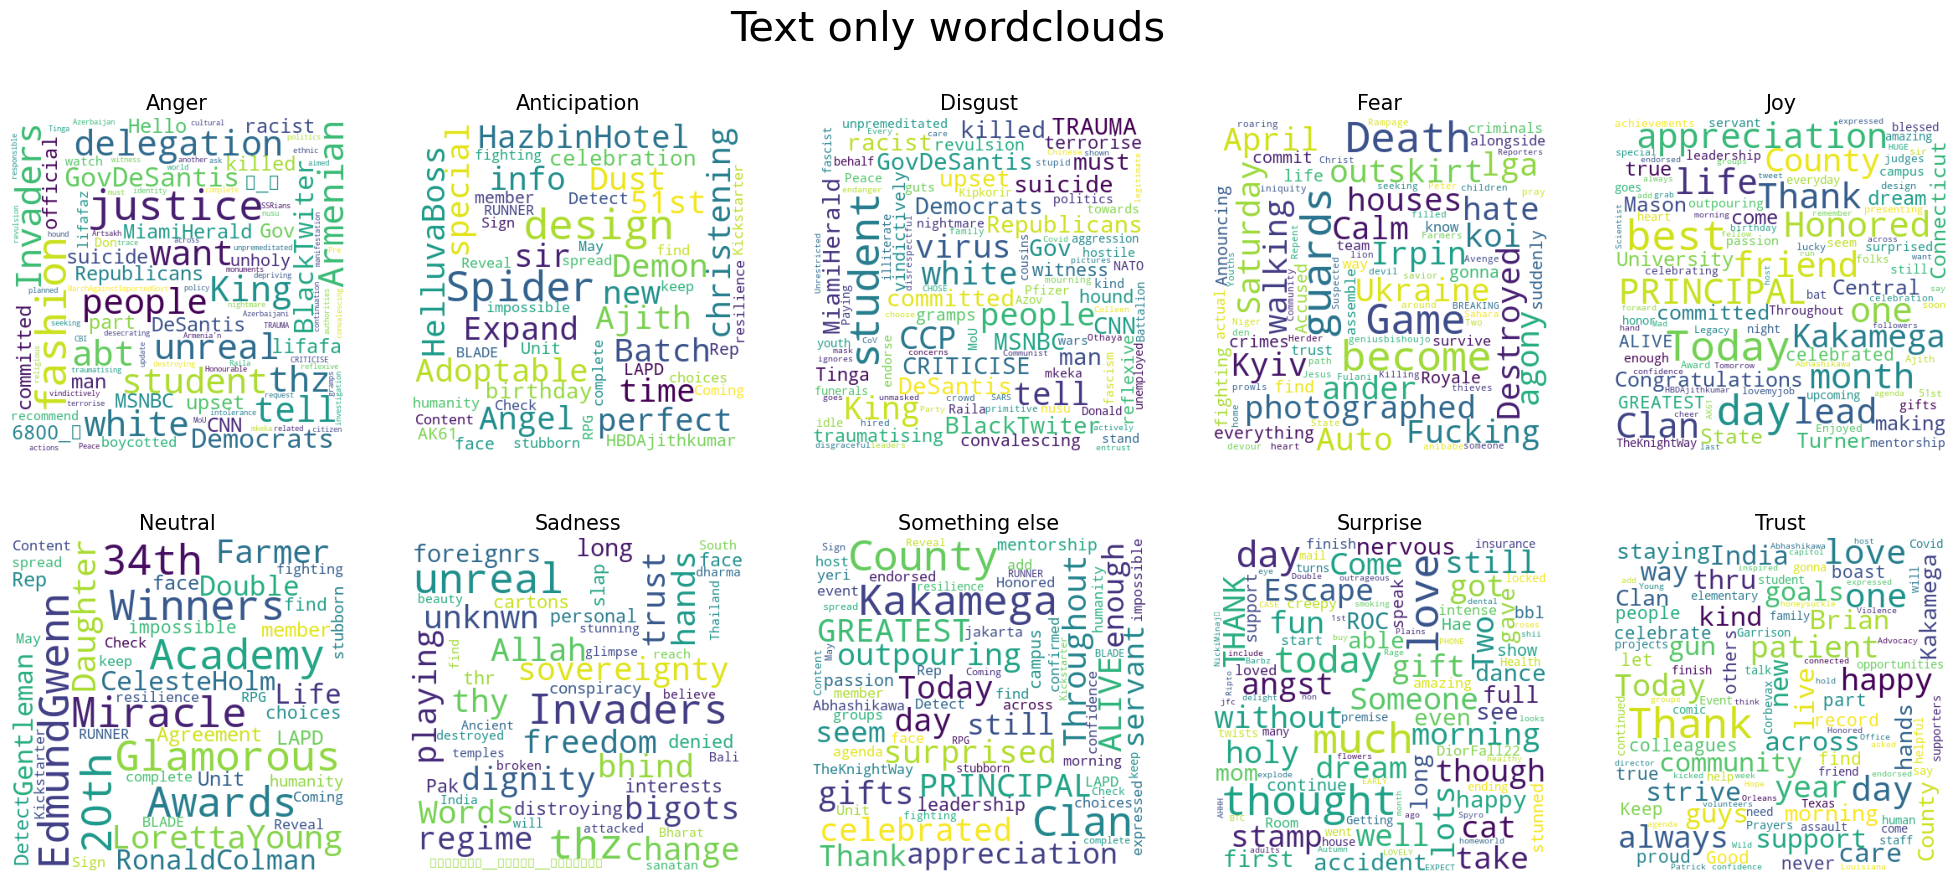

In [16]:
fig, axs = plt.subplots(2, 5, figsize=(25, 10))

for e, ax in zip(emotions, axs.flat):
    label = f"T_{e.capitalize()}"
    combined_text = ' '.join(df.loc[df[label] >= 2]['tweet'])

    pattern = re.compile("&amp")
    combined_text = re.sub(pattern, "", combined_text)

    # cleaning the tweet text, code taken from https://medium.com/codex/making-wordcloud-of-tweets-using-python-ca114b7a4ef4
    
    # remove emoji
    regex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    combined_text = re.sub(regex_pattern,'',combined_text)

    # remove urls
    pattern = re.compile(r'(https?://)?(www\.)?(\w+\.)?(\w+)(\.\w+)(/.+)?')
    combined_text = re.sub(pattern,'', combined_text)

    # remove @ mentions and hashes
    re_list = ["@[A-Za-z0–9_]+", '#']
    combined_re = re.compile( '|'.join( re_list) )
    combined_text = re.sub(combined_re,"",combined_text)
    
    

    wordcloud = (
        WordCloud(max_font_size=50, 
                max_words=100,       
                background_color="white",
                min_word_length=3,
                width=400,
                height=400)
        .generate(combined_text)
    )
    ax.set_title(e.capitalize(), fontsize=15)
    ax.imshow(wordcloud)
    ax.axis("off")

plt.suptitle("Text only wordclouds", fontsize=30)
plt.show()
plt.close()